In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

This is the target distribution we want to generate

In [2]:
x = np.arange(0, 10, 0.0001)
y = np.sin(x)
z = np.cos(x/3)

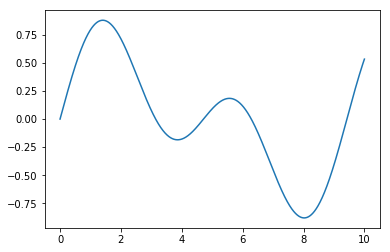

In [3]:
plt.plot(x, y*z)
plt.show()

In [4]:
def generate_data(num_samples):
    xs = np.random.choice(x, size=(num_samples, ), replace=False)
    ys = np.sin(xs)
    zs = np.cos(xs/3)
    return (np.asarray( xs + np.random.normal(scale=0.3, size=(num_samples, )), dtype=np.float32 ), 
            np.asarray( ys + np.random.normal(scale=0.3, size=(num_samples, )), dtype=np.float32 ), 
            np.asarray( zs + np.random.normal(scale=0.3, size=(num_samples, )), dtype=np.float32 ))

In [5]:
generate_data(1)

(array([5.151416], dtype=float32),
 array([-0.65472233], dtype=float32),
 array([-0.46165034], dtype=float32))

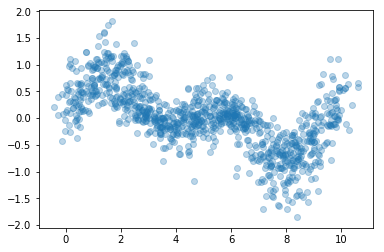

In [6]:
NUM_PTS = 1000

true_xs, true_ys, true_zs = generate_data(num_samples=NUM_PTS)

plt.scatter(true_xs, true_ys*true_zs, alpha=0.3)
plt.show()

In [7]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation=tf.nn.relu, input_shape=(3, )),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

discriminator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [8]:
NOISE_SIZE = 32

In [9]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NOISE_SIZE, )),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 27        
Total params: 691
Trainable params: 691
Non-trainable params: 0
_________________________________________________________________


In [10]:
disc_optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
gen_optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)

In [11]:
def train_one_iteration(k=100, batch_size=32, verbose=False):
    for step in range(k):
        noise = np.random.uniform(size=(batch_size, NOISE_SIZE))
        noise = np.asarray(noise, dtype=np.float32)
        true_xs, true_ys, true_zs = generate_data(batch_size)
        
        true_data = np.vstack([true_xs, true_ys, true_zs]).transpose()
        
        with tf.GradientTape() as t:
        
            pred_data = generator(noise)

            true_data_out = discriminator(true_data)
            pred_data_out = discriminator(pred_data)

            disc_loss = -tf.reduce_mean( tf.log(true_data_out) )
            disc_loss -= tf.reduce_mean( tf.log( tf.ones(batch_size, ) - pred_data_out ) )
            
        grads = t.gradient(disc_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
        
        if verbose:
            print('Discriminator Loss = {}'.format(disc_loss.numpy()))
            
    noise = np.random.uniform(size=(batch_size, NOISE_SIZE))
    noise = np.asarray(noise, dtype=np.float32)
    
    with tf.GradientTape() as t:
    
        pred_data = generator(noise)
        pred_data_out = discriminator(pred_data)
        
        generator_loss = tf.reduce_mean( tf.ones(batch_size, ) - pred_data_out )
        
    grads = t.gradient(generator_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))            
    
    if verbose:
        print('Generator Loss = {}'.format(generator_loss.numpy()))
        
    return disc_loss.numpy(), generator_loss.numpy()

In [13]:
TRAINING_EPOCHS = 50000

discriminator_losses = []
generator_losses = []

for epoch in range(TRAINING_EPOCHS):
    disc_loss, gen_loss = train_one_iteration()
    discriminator_losses.append(disc_loss)
    generator_losses.append(gen_loss)
    if (epoch + 1) % 100 == 0:
        print('Epoch = {}'.format(epoch))
        print('Average Discriminator Loss = {}, Average Generator Loss = {}'.format(
            np.mean(discriminator_losses[-100*100:]),
            np.mean(generator_losses[-100:])
        ))
        print()
    

Epoch = 99
Average Discriminator Loss = 0.34784260392189026, Average Generator Loss = 0.8995519876480103

Epoch = 199
Average Discriminator Loss = 0.5000202655792236, Average Generator Loss = 0.7894628047943115

Epoch = 299
Average Discriminator Loss = 0.6111788153648376, Average Generator Loss = 0.7279418706893921

Epoch = 399
Average Discriminator Loss = 0.6803629398345947, Average Generator Loss = 0.7044522166252136

Epoch = 499
Average Discriminator Loss = 0.7204218506813049, Average Generator Loss = 0.6975342631340027

Epoch = 599
Average Discriminator Loss = 0.7484234571456909, Average Generator Loss = 0.7075698971748352

Epoch = 699
Average Discriminator Loss = 0.7693415880203247, Average Generator Loss = 0.6978336572647095

Epoch = 799
Average Discriminator Loss = 0.7841140627861023, Average Generator Loss = 0.6969649791717529

Epoch = 899
Average Discriminator Loss = 0.7940220832824707, Average Generator Loss = 0.7012777924537659

Epoch = 999
Average Discriminator Loss = 0.804

Epoch = 7799
Average Discriminator Loss = 1.0488682985305786, Average Generator Loss = 0.5702426433563232

Epoch = 7899
Average Discriminator Loss = 1.0508114099502563, Average Generator Loss = 0.572681725025177

Epoch = 7999
Average Discriminator Loss = 1.0529751777648926, Average Generator Loss = 0.5656489729881287

Epoch = 8099
Average Discriminator Loss = 1.054979920387268, Average Generator Loss = 0.5678779482841492

Epoch = 8199
Average Discriminator Loss = 1.0570521354675293, Average Generator Loss = 0.563767671585083

Epoch = 8299
Average Discriminator Loss = 1.0590887069702148, Average Generator Loss = 0.5642869472503662

Epoch = 8399
Average Discriminator Loss = 1.0609626770019531, Average Generator Loss = 0.5687717199325562

Epoch = 8499
Average Discriminator Loss = 1.0628466606140137, Average Generator Loss = 0.575751781463623

Epoch = 8599
Average Discriminator Loss = 1.0647653341293335, Average Generator Loss = 0.5654622912406921

Epoch = 8699
Average Discriminator Loss =

Epoch = 15499
Average Discriminator Loss = 1.2360882759094238, Average Generator Loss = 0.5397606492042542

Epoch = 15599
Average Discriminator Loss = 1.2370707988739014, Average Generator Loss = 0.5478565096855164

Epoch = 15699
Average Discriminator Loss = 1.2378597259521484, Average Generator Loss = 0.5399885773658752

Epoch = 15799
Average Discriminator Loss = 1.2388050556182861, Average Generator Loss = 0.5400921106338501

Epoch = 15899
Average Discriminator Loss = 1.23984694480896, Average Generator Loss = 0.5390753149986267

Epoch = 15999
Average Discriminator Loss = 1.2407137155532837, Average Generator Loss = 0.5449733138084412

Epoch = 16099
Average Discriminator Loss = 1.2412726879119873, Average Generator Loss = 0.5398248434066772

Epoch = 16199
Average Discriminator Loss = 1.2420341968536377, Average Generator Loss = 0.5403879880905151

Epoch = 16299
Average Discriminator Loss = 1.2428101301193237, Average Generator Loss = 0.5382914543151855

Epoch = 16399
Average Discrimi

Epoch = 23199
Average Discriminator Loss = 1.3186259269714355, Average Generator Loss = 0.5156002640724182

Epoch = 23299
Average Discriminator Loss = 1.3195267915725708, Average Generator Loss = 0.5128638744354248

Epoch = 23399
Average Discriminator Loss = 1.3208351135253906, Average Generator Loss = 0.5104444622993469

Epoch = 23499
Average Discriminator Loss = 1.3218774795532227, Average Generator Loss = 0.5109673142433167

Epoch = 23599
Average Discriminator Loss = 1.3227914571762085, Average Generator Loss = 0.5130517482757568

Epoch = 23699
Average Discriminator Loss = 1.3236334323883057, Average Generator Loss = 0.5180262327194214

Epoch = 23799
Average Discriminator Loss = 1.3244423866271973, Average Generator Loss = 0.5144367814064026

Epoch = 23899
Average Discriminator Loss = 1.3253976106643677, Average Generator Loss = 0.5127261877059937

Epoch = 23999
Average Discriminator Loss = 1.3263417482376099, Average Generator Loss = 0.51114821434021

Epoch = 24099
Average Discrimi

Epoch = 30899
Average Discriminator Loss = 1.3595832586288452, Average Generator Loss = 0.5112594366073608

Epoch = 30999
Average Discriminator Loss = 1.3597325086593628, Average Generator Loss = 0.508651077747345

Epoch = 31099
Average Discriminator Loss = 1.359666347503662, Average Generator Loss = 0.508876621723175

Epoch = 31199
Average Discriminator Loss = 1.359452486038208, Average Generator Loss = 0.5198646783828735

Epoch = 31299
Average Discriminator Loss = 1.359376072883606, Average Generator Loss = 0.5189405679702759

Epoch = 31399
Average Discriminator Loss = 1.3594000339508057, Average Generator Loss = 0.5164117217063904

Epoch = 31499
Average Discriminator Loss = 1.35953950881958, Average Generator Loss = 0.5122132301330566

Epoch = 31599
Average Discriminator Loss = 1.3596432209014893, Average Generator Loss = 0.506309986114502

Epoch = 31699
Average Discriminator Loss = 1.3596265316009521, Average Generator Loss = 0.507088840007782

Epoch = 31799
Average Discriminator L

Epoch = 38599
Average Discriminator Loss = 1.3595154285430908, Average Generator Loss = 0.5219638347625732

Epoch = 38699
Average Discriminator Loss = 1.359554409980774, Average Generator Loss = 0.5080065727233887

Epoch = 38799
Average Discriminator Loss = 1.359667181968689, Average Generator Loss = 0.5058862566947937

Epoch = 38899
Average Discriminator Loss = 1.3597954511642456, Average Generator Loss = 0.5078051090240479

Epoch = 38999
Average Discriminator Loss = 1.3600425720214844, Average Generator Loss = 0.5092257261276245

Epoch = 39099
Average Discriminator Loss = 1.3602027893066406, Average Generator Loss = 0.5077016353607178

Epoch = 39199
Average Discriminator Loss = 1.3603291511535645, Average Generator Loss = 0.5073984265327454

Epoch = 39299
Average Discriminator Loss = 1.3606187105178833, Average Generator Loss = 0.5075002312660217

Epoch = 39399
Average Discriminator Loss = 1.3605133295059204, Average Generator Loss = 0.508055567741394

Epoch = 39499
Average Discrimin

Epoch = 46299
Average Discriminator Loss = 1.3609222173690796, Average Generator Loss = 0.5109494924545288

Epoch = 46399
Average Discriminator Loss = 1.3610191345214844, Average Generator Loss = 0.5068861246109009

Epoch = 46499
Average Discriminator Loss = 1.3611139059066772, Average Generator Loss = 0.5088489651679993

Epoch = 46599
Average Discriminator Loss = 1.3611754179000854, Average Generator Loss = 0.5089542269706726

Epoch = 46699
Average Discriminator Loss = 1.361205816268921, Average Generator Loss = 0.5102884769439697

Epoch = 46799
Average Discriminator Loss = 1.361022710800171, Average Generator Loss = 0.5147393345832825

Epoch = 46899
Average Discriminator Loss = 1.3608649969100952, Average Generator Loss = 0.519533097743988

Epoch = 46999
Average Discriminator Loss = 1.3609833717346191, Average Generator Loss = 0.515672504901886

Epoch = 47099
Average Discriminator Loss = 1.3612862825393677, Average Generator Loss = 0.5081005096435547

Epoch = 47199
Average Discrimina

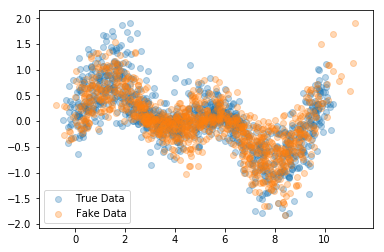

In [16]:
NUM_PTS = 1000

true_xs, true_ys, true_zs = generate_data(NUM_PTS)
plt.scatter(true_xs, true_ys*true_zs, alpha=0.3, label='True Data')

noise = np.random.uniform(size=(NUM_PTS, NOISE_SIZE))
noise = np.asarray(noise, dtype=np.float32)
fake_data = generator(noise)
fake_xs, fake_ys, fake_zs = fake_data[:, 0], fake_data[:, 1], fake_data[:, 2]
plt.scatter(fake_xs, fake_ys*fake_zs, alpha=0.3, label='Fake Data')
plt.legend()

plt.show()

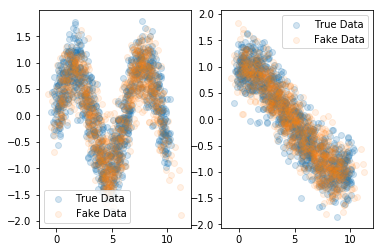

In [18]:
plt.figure()

plt.subplot(121)
plt.scatter(true_xs, true_ys, label='True Data', alpha=0.2)
plt.scatter(fake_xs, fake_ys, label='Fake Data', alpha=0.1)
plt.legend()

plt.subplot(122)
plt.scatter(true_xs, true_zs, label='True Data', alpha=0.2)
plt.scatter(fake_xs, fake_zs, label='Fake Data', alpha=0.1)
plt.legend()
plt.show()

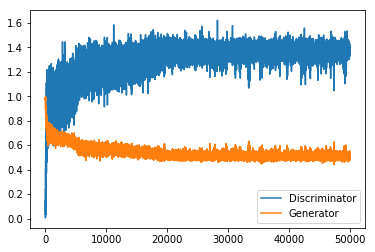

In [23]:
plt.figure()

plt.plot(discriminator_losses, label='Discriminator')
plt.plot(generator_losses, label='Generator')
plt.legend()
plt.title('Generator and Discriminator Losses over time')

plt.show()

In [24]:
generator.save_weights('generator_1.h5')
discriminator.save_weights('discriminator_1.h5')